### Исследование внутренних связей между песнями Pyrokinesis на основе текстов и данных с Яндекс Музыки:повторяющиеся мотивы, образы и лексика.

In [ ]:
import json
import requests
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
from wordcloud import WordCloud
from yandex_music import Client

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from pymorphy3 import MorphAnalyzer

# NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulyana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ulyana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Загрузка данных

#### parse_artist_tqdm.py

In [ ]:
# Set session ID from Yandex Music (Required Yandex Plus)
SESSION_ID = 'token'

client = Client(SESSION_ID).init()

search_result = client.search('Pyrokinesis', type_='artist')
artist = search_result.artists.results[0]

tracks = []
for track in tqdm(client.artists_tracks(artist.id, page_size=100), desc="Парсинг треков"):
    track_data = {
        'title': track.title if track.title else '-',
        'album': track.albums[0].title if track.albums else '-',
        'release_year': track.albums[0].year if track.albums else '-',
        'lyrics': requests.get(track.get_lyrics()['download_url'])
                                   .text
                                   .replace('\n',' ')
                                   .replace('\r',' ')
                                   if track.get_lyrics() else '-',
    }
    tracks.append(track_data)

with open('../data/raw/pyrokinesis_raw.json', 'w', encoding='utf-8') as f:
    json.dump(tracks, f, ensure_ascii=False, indent=4)

print(f'Сохранено {len(tracks)} треков исполнителя {artist.name} в pyrokinesis_raw.json')

Парсинг треков: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s]

Сохранено 100 треков исполнителя pyrokinesis в pyrokinesis_raw.json


## Очистка данных и подготовка к анализу

#### json_to_csv.py

In [21]:
json_data_path = '../data/raw/pyrokinesis_raw.json'
csv_data_path = '../data/processed/pyrokinesis.csv'

with open(json_data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df['lyrics'] = df['lyrics'].str.replace(r'[",.:!?()—–-]', '', regex=True)
df['lyrics'] = df['lyrics'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['title'] = df['title'].astype(str)
df['album'] = df['album'].astype(str)
df['release_year'] = df['release_year'].astype(int)

df.to_csv(csv_data_path, index=False, encoding='utf-8')

#### Начальные 5 строк

In [22]:
df.head(5)

,title,album,release_year,lyrics
0,Негативное мышление,Висхолдинг,2025,Мне вроде бы как всё равно На тебя уже очень д...
1,Днями-ночами,Днями-ночами,2020,Почтим святое да Но часики спешат и то едва Эй...
2,Тернии,Прощай и люби меня,2025,Сквозь тернии к звёздам До Луны и обратно Мину...
3,Цветами радуги,Цветами радуги,2019,Привиделось как под кайфом мне Размазанный и п...
4,молчаливое согласие небес,mea maxima culpa,2025,Мира полотно Человек пытается понять но не дан...


#### Конечные 5 строк

In [23]:
df.tail(5)

,title,album,release_year,lyrics
95,Мискузи мадам аутро,"Питер, чай, не Франция",2020,Je suis folle D'être folle de moi Tu es fou Je...
96,Восток моей юности,акустический,2019,Восток моей юности запад пройденных дней Я на ...
97,Абсолютно чёрное тело,Абсолютно чёрное тело,2020,Если можешь кричи Из ста тысяч таких голосов р...
98,в джазе одни девчонки,геометрия тьмы,2022,Оркестр из Миннесоты И в джазе одни девчонки Я...
99,Ангелы не летают,МОЯ МИЛАЯ ПУСТОТА,2019,Через красные колючки дети тянут ручки к цвета...


#### Типы данных

In [24]:
df.dtypes

title           object
album           object
release_year     int64
lyrics          object
dtype: object

#### Количество пропусков

In [25]:
print((df == '-').sum())

title           0
album           0
release_year    0
lyrics          0
dtype: int64


#### Первичный анализ

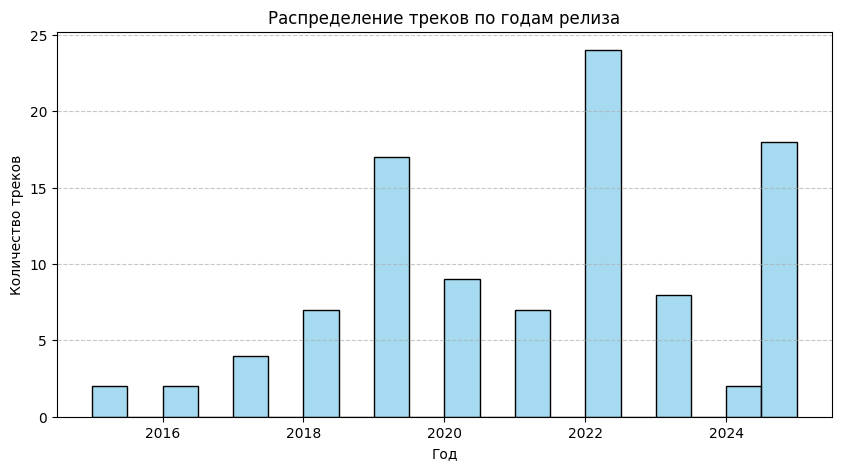

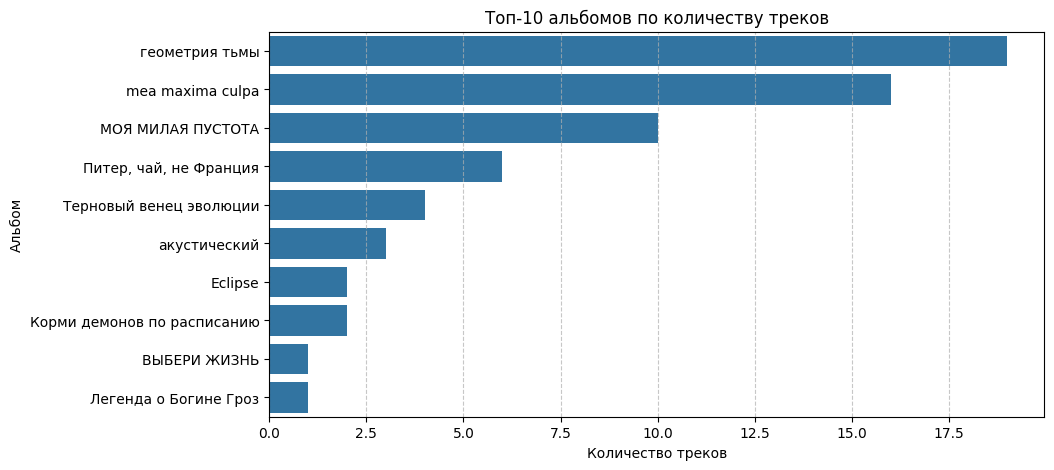

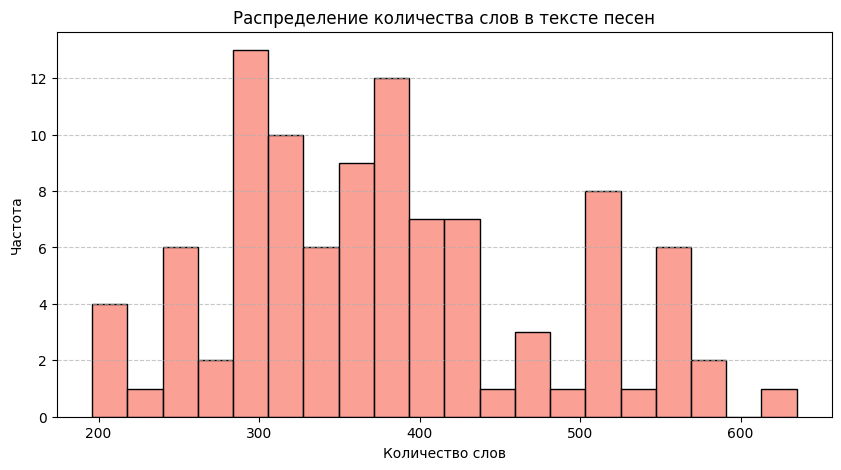

Статистика по длине текста песен (слов):
count    100.000000
mean     378.940000
std      100.109921
min      196.000000
25%      300.750000
50%      369.000000
75%      433.250000
max      635.000000
Name: lyrics_wordcount, dtype: float64


In [26]:
csv_data_path = '../data/processed/pyrokinesis.csv'
df = pd.read_csv(csv_data_path)

plt.figure(figsize=(10, 5))
sns.histplot(df['release_year'], bins=20, kde=False, color='skyblue')
plt.title('Распределение треков по годам релиза')
plt.xlabel('Год')
plt.ylabel('Количество треков')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

top_albums = df['album'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_albums.values, y=top_albums.index)
plt.title('Топ-10 альбомов по количеству треков')
plt.xlabel('Количество треков')
plt.ylabel('Альбом')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

df['lyrics_length'] = df['lyrics'].apply(lambda x: len(str(x)))
df['lyrics_wordcount'] = df['lyrics'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(df['lyrics_wordcount'], bins=20, color='salmon')
plt.title('Распределение количества слов в тексте песен')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

print('Статистика по длине текста песен (слов):')
print(df['lyrics_wordcount'].describe())


## Анализ и визуализация

Весь мыслительный процесс, связанный с аналитикой ваших данных, а также построения визуализаций поместите в данный раздел

#### Гипотеза 1: В песнях Pyrokinesis часто встречаются повторяющиеся мотивы и образы (например, «любовь», «война», «пустота» и др.), характерные для творчества группы.

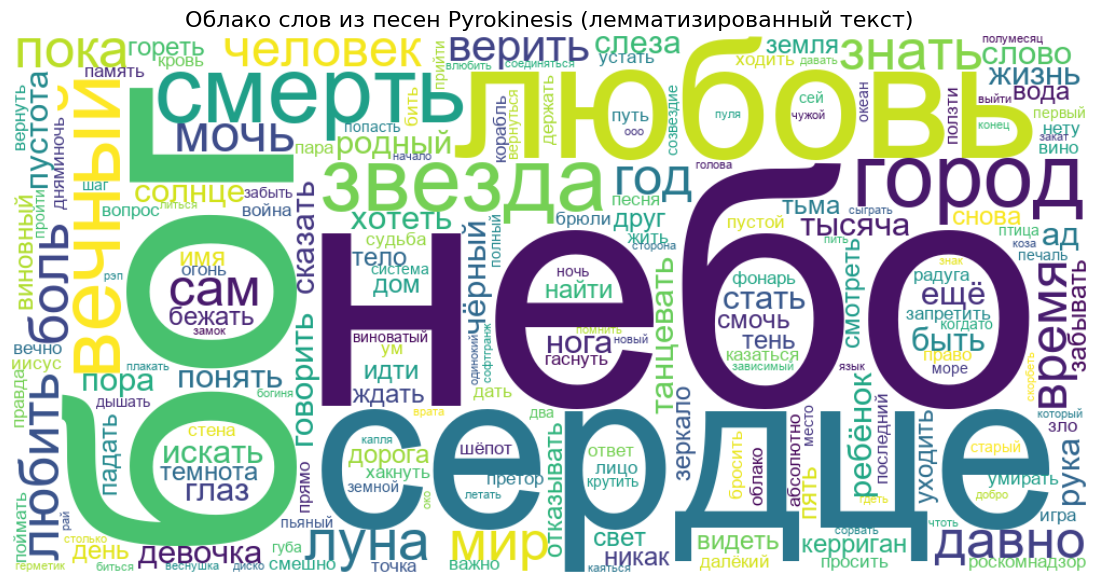

In [27]:
russian_stopwords = stopwords.words('russian')

df = pd.read_csv('../data/processed/pyrokinesis.csv')
df = df.dropna(subset=['lyrics'])

morph = MorphAnalyzer()

excluded_lemmas = {
    'мой', 'твой', 'свой', 'наш', 'ваш', 'их', 'его', 'её', 'ее',
    'тот', 'этот', 'такой', 'таков', 'всякий', 'любой', 'некоторый', 'самый',
    'один', 'другой', 'каждый', 'иной', 'весь', 'всё', 'все', 'никакой'
}

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in russian_stopwords]
    
    lemmas = []
    for token in tokens:
        parsed = morph.parse(token)[0]
        pos = parsed.tag.POS
        lemma = parsed.normal_form
        if (
            pos not in {'PREP', 'PRCL', 'CONJ', 'NPRO', 'INTJ'} and
            lemma not in excluded_lemmas
        ):
            lemmas.append(lemma)
    
    return ' '.join(lemmas)

df['lemmatized_lyrics'] = df['lyrics'].apply(lemmatize_text)

vectorizer = CountVectorizer(
    token_pattern=r'\b[а-яА-ЯёЁ]{2,}\b'
)

X = vectorizer.fit_transform(df['lemmatized_lyrics'])
word_freq = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()
freq_dict = dict(zip(vocab, word_freq))

wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/arial.ttf',
    width=1000,
    height=500,
    background_color='white'
).generate_from_frequencies(freq_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов из песен Pyrokinesis (лемматизированный текст)', fontsize=16)
plt.show()


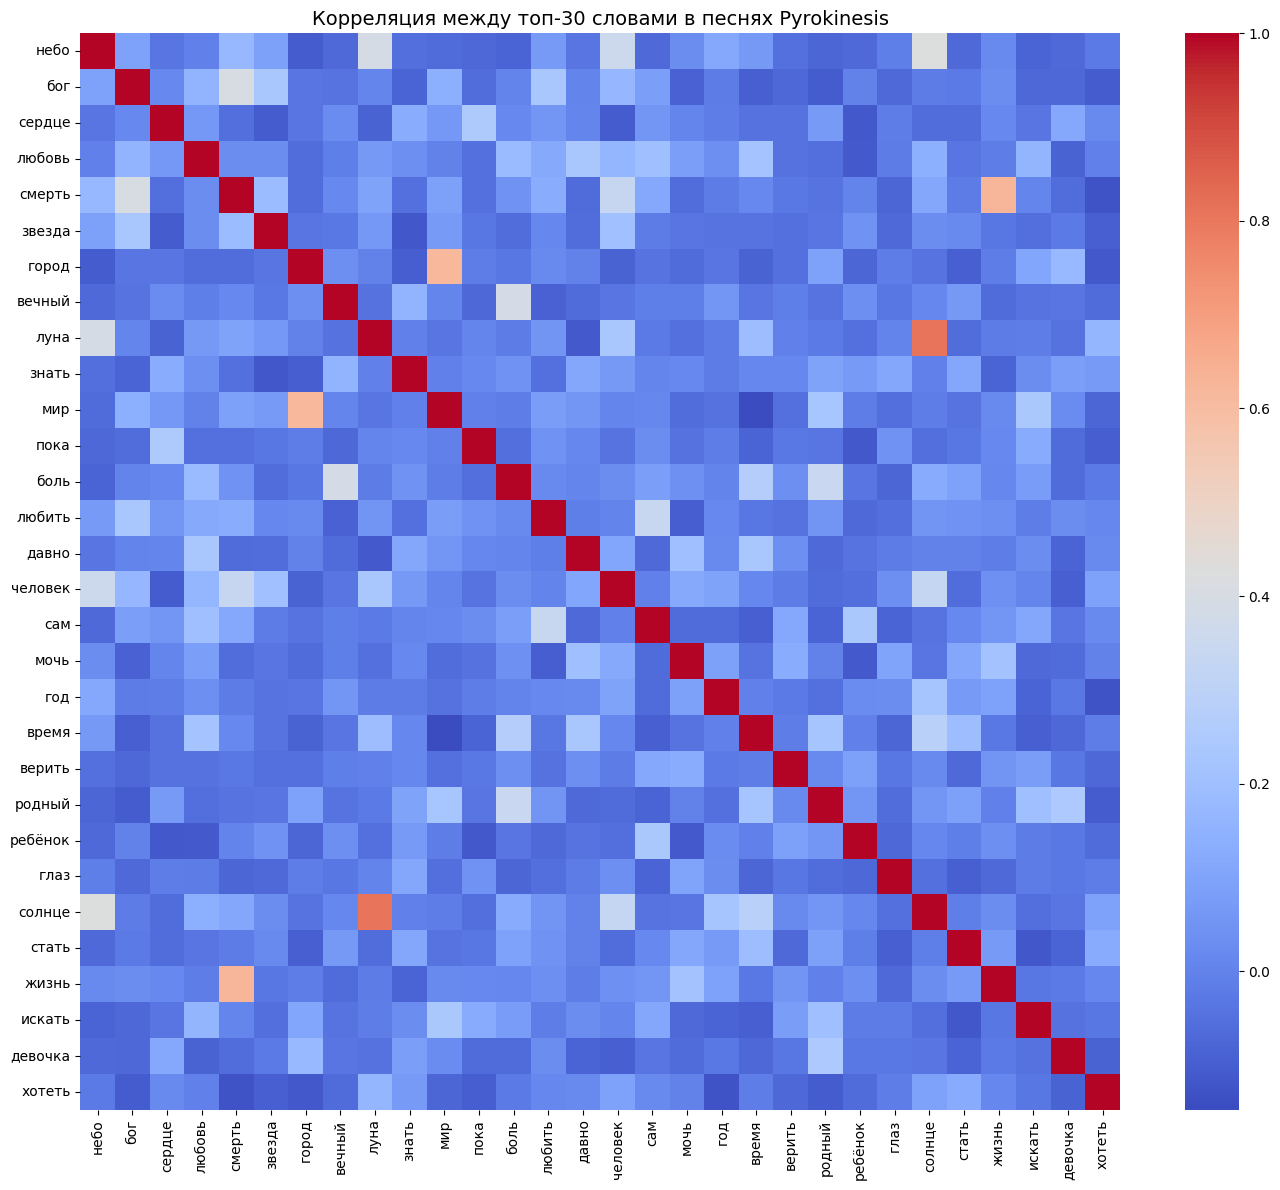

In [28]:
df_words = pd.DataFrame(X.toarray(), columns=vocab)

corr_matrix = df_words.corr()

top_words = sorted(freq_dict, key=freq_dict.get, reverse=True)[:30]
top_corr = corr_matrix.loc[top_words, top_words]

plt.figure(figsize=(14, 12))
sns.heatmap(top_corr, annot=False, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Корреляция между топ-30 словами в песнях Pyrokinesis', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
mask = np.triu(np.ones(top_corr.shape), k=1).astype(bool)
corr_pairs = top_corr.where(mask)

corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Word 1', 'Word 2', 'Correlation']

corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)

print(corr_pairs.head(20))

      Word 1   Word 2  Correlation
219     луна   солнце     0.808678
131   смерть    жизнь     0.624339
162    город      мир     0.618573
23      небо   солнце     0.425736
31       бог   смерть     0.403093
7       небо     луна     0.390485
186   вечный     боль     0.386622
14      небо  человек     0.356576
290     боль   родный     0.342785
301   любить      сам     0.338106
120   смерть  человек     0.335340
338  человек   солнце     0.329554
384    время   солнце     0.284553
288     боль    время     0.270994
65    сердце     пока     0.251116
405   родный  девочка     0.242839
349      сам  ребёнок     0.240936
261      мир   искать     0.238698
319    давно    время     0.233075
40       бог   любить     0.232901


На основе анализа корреляционной матрицы по топ-30 словам из песен Pyrokinesis можно подтвердить гипотезу о том, что в текстах группы часто встречаются повторяющиеся мотивы и образы.

Высокая корреляция между парами слов, такими как «луна — солнце», «смерть — жизнь», «бог — смерть», «небо — солнце», указывает на использование сильных символических образов и противопоставлений, придающих лирике глубокий философский смысл.

Связи между словами «город — мир», «вечный — боль», «небо — человек» отражают постоянное обращение к темам пространства, времени и человеческих переживаний.

Эмоциональная составляющая проявляется в парах «любить — сам», «боль — родной», «сердце — пока», что подчеркивает насыщенность песен личными чувствами и отношениями.

Кроме того, мотивы времени и поиска смысла выражены в корреляциях «время — солнце», «мир — искать», «давно — время».

Таким образом, анализ подтверждает, что творчество Pyrokinesis наполнено характерными повторяющимися образами и мотивами, создающими целостный и эмоционально насыщенный лирический мир.

#### Гипотеза 2: В творчестве Pyrokinesis присутствует чёткое тематическое разнообразие, которое выражается в выделении нескольких смысловых кластеров песен, отражающих разные эмоциональные и концептуальные направления — от личной лирики и романтики до философских, мифологических и социальных мотивов.

cluster
0    17
2    17
6    14
7    12
3     9
1     9
5     7
4     6
9     5
8     4
Name: count, dtype: int64


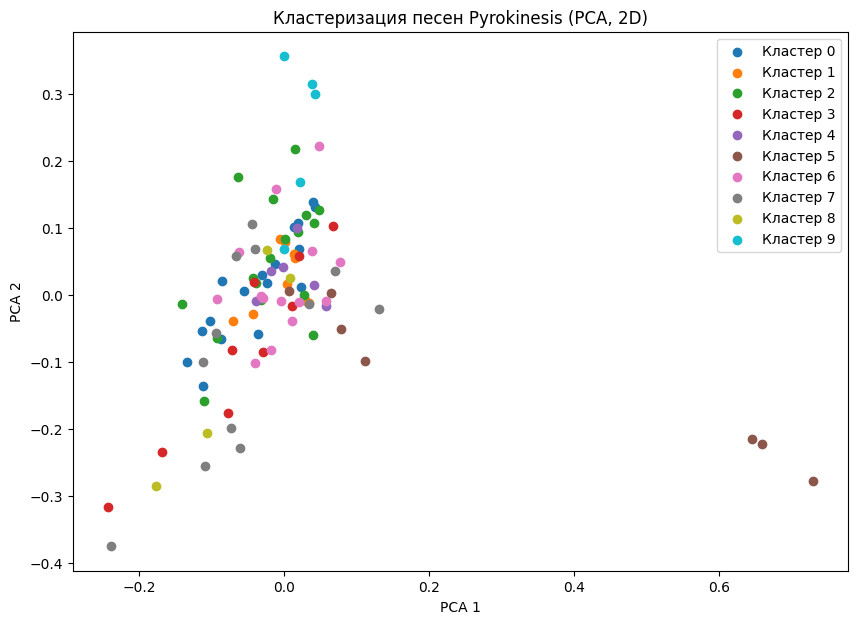


Кластер 0 - первые 3 песни:
                   title              album  release_year
0    Негативное мышление         Висхолдинг          2025
7    её влюбленные глаза   mea maxima culpa          2025
11  Сигаретка без кнопки  МОЯ МИЛАЯ ПУСТОТА          2019

Кластер 1 - первые 3 песни:
                                              title  \
12  в ад только перед тобой в рай только после тебя   
14                                         50 на 50   
15                                  точки моих опор   

                                              album  release_year  
12  в ад только перед тобой в рай только после тебя          2022  
14                                 mea maxima culpa          2025  
15                                 mea maxima culpa          2025  

Кластер 2 - первые 3 песни:
               title                   album  release_year
8      Некуда бежать            ВЫБЕРИ ЖИЗНЬ          2021
9   моя великая вина        mea maxima culpa          2025
10       За

In [30]:
russian_stopwords = stopwords.words('russian')

df = pd.read_csv('../data/processed/pyrokinesis.csv')
df = df.dropna(subset=['lyrics'])

morph = MorphAnalyzer()

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in russian_stopwords]
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]
    return ' '.join(lemmas)

df['lemmatized_lyrics'] = df['lyrics'].apply(lemmatize_text)

vectorizer = TfidfVectorizer(min_df=2, max_df=0.8, token_pattern=r'\b[а-яё]{3,}\b')
X = vectorizer.fit_transform(df['lemmatized_lyrics'])

num_clusters = 10  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

df['cluster'] = kmeans.labels_

print(df['cluster'].value_counts())

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
for cluster_num in range(num_clusters):
    plt.scatter(
        X_pca[df['cluster'] == cluster_num, 0],
        X_pca[df['cluster'] == cluster_num, 1],
        label=f'Кластер {cluster_num}'
    )
plt.legend()
plt.title('Кластеризация песен Pyrokinesis (PCA, 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

for cluster_num in range(num_clusters):
    print(f'\nКластер {cluster_num} - первые 3 песни:')
    print(df[df['cluster'] == cluster_num][['title', 'album', 'release_year']].head(3))

Анализ кластеров показывает, что песни группы разделяются на несколько тематических и смысловых групп, отражающих различные мотивы и стили в творчестве.

- Кластер 0 объединяет песни с личностными и эмоциональными темами — «Негативное мышление», «влюбленные глаза», «Сигаретка без кнопки». Этот кластер отражает интимную, лирическую, рефлексивную сторону творчества.
- Кластер 1 характеризуется глубокими, философскими или драматичными мотивами — «в ад только перед тобой в рай только после тебя», «50 на 50», «точки моих опор». Песни касаются внутренних переживаний, борьбы, жизненных выборов.
- Кластер 2 включает песни с темами борьбы и зависимости — «Некуда бежать», «моя великая вина», «Зависимость». Акцент на проблемах внутренних конфликтов и сложных состояний.
- Кластер 3 содержит песни с образами и мифологическими мотивами — «Легенда о Богине Гроз», «Легенда о Боге Смерти», что объединяет композиции с эпическим, сказочным, символическим содержанием.
- Кластер 4 объединяет поэтичные и образные песни — «Я приду к тебе с клубникой в декабре», «Дворцовый мост», «Цветочек зла». Здесь присутствует художественная, метафорическая лирика.
- Кластер 5 представлен песнями с яркими, экспериментальными и социально значимыми названиями — «аморе аморе», «РКН», «Помогите Элли». В этот кластер входят песни с актуальными, молодежными или ироничными темами.
- Кластер 6 характеризуется романтическими и ностальгическими названиями — «Тернии», «Цветами радуги», «Да что романтичного в птичках?». Этот кластер сосредоточен на отношениях и чувствах.
- Кластер 7 связан с религиозной и мистической тематикой — «тёмная сторона Бога», «дьявол в деталях», «звёзды все принадлежат богам». Акцент на образах добра и зла, духовных исканий.
- Кластер 8 включает песни с эмоциональной окраской и лирической нежностью — «молчаливое согласие небес», «отказываю небу», «я краснею при тебе как...». Тематика — отношения, чувства, романтика.
- Кластер 9 содержит композиции с мрачными, мистическими и драматическими образами — «Чёрное солнышко», «чёрное сердце», «докучные сказки». Песни имеют тёмное, атмосферное звучание.

### Заключение

В рамках данного исследования выявлялись повторяющиеся мотивы, образы и темы в текстах песен Pyrokinesis, а также определялись лексические закономерности с помощью методов анализа текста и кластеризации.

Удалось провести:
- предварительную обработку данных (очистка и лемматизация текстов);
- векторизацию текстов с помощью TF-IDF;
- построение матрицы корреляций между словами и выделение часто сочетающихся пар;
- кластеризацию песен с помощью алгоритма KMeans;
- интерпретацию содержимого кластеров на основе тематики песен.

На основе анализа можно подтвердить, что в песнях Pyrokinesis действительно прослеживаются устойчивые мотивы и образы (любовь, смерть, мистика, внутренние конфликты), что согласуется с изначальной гипотезой.

Что не удалось:
- не были учтены дополнительные уровни анализа (эмоциональный тон, рифмы, фонетика), которые могли бы углубить исследование;

Как можно улучшить исследование:
- добавить тематическое моделирование (например, LDA), чтобы точнее выявить латентные темы;
- провести более глубокий анализ временной динамики тем и лексики;
- использовать эмбеддинги слов (Word2Vec, FastText) для выявления семантической близости;

Кому может быть полезно это исследование:
- поклонникам группы и музыкальным критикам для более глубокого понимания лирики;
- культурологам и лингвистам, исследующим тексты современной альтернативной музыки;
- авторам и продюсерам, интересующимся анализом текстов для создания содержательных песен;
- студентам и исследователям, осваивающим методы текстовой аналитики и NLP на русскоязычных данных.

In [31]:
# Final csv
df.to_csv('../data/processed/pyrokinesis_after.csv', index=False, encoding='utf-8')